In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWX5.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,42.639999,42.700001,42.349998,42.639999,35.164452,1108600
1,1/3/2013,42.380001,42.560001,42.200001,42.259998,34.851074,273200
2,1/4/2013,42.240002,42.520000,42.150002,42.490002,35.040752,297200
3,1/7/2013,42.080002,42.259998,42.070000,42.200001,34.801601,258700
4,1/8/2013,42.090000,42.090000,41.810001,41.919998,34.570686,90400


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 608.449970.3, cost: 0.171465, total money: 2958.599960
epoch: 20, total rewards: 529.479969.3, cost: 0.028663, total money: 7016.459976
epoch: 30, total rewards: 482.229976.3, cost: 0.003623, total money: 8862.179981
epoch: 40, total rewards: 472.329971.3, cost: 0.001089, total money: 9306.709976
epoch: 50, total rewards: 459.519977.3, cost: 0.000608, total money: 9837.789982
epoch: 60, total rewards: 359.539970.3, cost: 0.000796, total money: 10261.869972
epoch: 70, total rewards: 295.249966.3, cost: 0.000846, total money: 10295.249966
epoch: 80, total rewards: 323.309963.3, cost: 0.000965, total money: 10323.309963
epoch: 90, total rewards: 206.849960.3, cost: 0.000649, total money: 10206.849960
epoch: 100, total rewards: 193.999965.3, cost: 0.000634, total money: 10193.999965
epoch: 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 42.490002, total balance 9957.509998
day 3, sell 1 unit at price 42.200001, investment -0.682516 %, total balance 9999.709999,
day 5: buy 1 unit at price 42.189999, total balance 9957.520000
day 6, sell 1 unit at price 42.669998, investment 1.137709 %, total balance 10000.189999,
day 9: buy 1 unit at price 42.720001, total balance 9957.469997
day 11: buy 1 unit at price 42.810001, total balance 9914.659996
day 12: buy 1 unit at price 42.869999, total balance 9871.789997
day 14, sell 1 unit at price 42.790001, investment 0.163857 %, total balance 9914.579998,
day 15, sell 1 unit at price 42.849998, investment 0.093429 %, total balance 9957.429996,
day 16: buy 1 unit at price 43.180000, total balance 9914.249996
day 17, sell 1 unit at price 42.910000, investment 0.093307 %, total balance 9957.159996,
day 19, sell 1 unit at price 43.279999, investment 0.231585 %, total balance 10000.439995,
day 21: buy 1 unit at price 43.490002, total balance 9956.949993
day 22,

day 169, sell 1 unit at price 42.849998, investment 1.733142 %, total balance 9957.579990,
day 170, sell 1 unit at price 42.959999, investment 1.129942 %, total balance 10000.539989,
day 172: buy 1 unit at price 43.919998, total balance 9956.619991
day 174, sell 1 unit at price 44.500000, investment 1.320587 %, total balance 10001.119991,
day 175: buy 1 unit at price 44.189999, total balance 9956.929993
day 176: buy 1 unit at price 44.400002, total balance 9912.529991
day 177: buy 1 unit at price 44.770000, total balance 9867.759991
day 178, sell 1 unit at price 44.820000, investment 1.425664 %, total balance 9912.579990,
day 179: buy 1 unit at price 46.040001, total balance 9866.539989
day 180, sell 1 unit at price 45.830002, investment 3.220721 %, total balance 9912.369991,
day 181, sell 1 unit at price 45.349998, investment 1.295506 %, total balance 9957.719990,
day 182, sell 1 unit at price 45.349998, investment -1.498702 %, total balance 10003.069988,
day 184: buy 1 unit at price 

day 322: buy 1 unit at price 46.509998, total balance 9979.400005
day 324: buy 1 unit at price 46.770000, total balance 9932.630005
day 325, sell 1 unit at price 47.029999, investment 1.118040 %, total balance 9979.660004,
day 327, sell 1 unit at price 47.169998, investment 0.855244 %, total balance 10026.830002,
day 331: buy 1 unit at price 46.910000, total balance 9979.920002
day 332: buy 1 unit at price 47.230000, total balance 9932.690002
day 333, sell 1 unit at price 47.349998, investment 0.937963 %, total balance 9980.040001,
day 334, sell 1 unit at price 47.369999, investment 0.296420 %, total balance 10027.410000,
day 336: buy 1 unit at price 47.320000, total balance 9980.090000
day 337, sell 1 unit at price 47.279999, investment -0.084533 %, total balance 10027.369999,
day 338: buy 1 unit at price 47.410000, total balance 9979.959999
day 339: buy 1 unit at price 47.389999, total balance 9932.570000
day 340, sell 1 unit at price 47.320000, investment -0.189834 %, total balance 

day 513: buy 1 unit at price 42.310001, total balance 9433.170006
day 514: buy 1 unit at price 42.770000, total balance 9390.400005
day 516, sell 1 unit at price 43.270000, investment 1.787820 %, total balance 9433.670006,
day 517, sell 1 unit at price 43.549999, investment 0.461363 %, total balance 9477.220005,
day 519, sell 1 unit at price 43.770000, investment 1.085453 %, total balance 9520.990005,
day 520, sell 1 unit at price 43.759998, investment 0.413025 %, total balance 9564.750004,
day 522: buy 1 unit at price 43.549999, total balance 9521.200004
day 523, sell 1 unit at price 42.869999, investment -1.966615 %, total balance 9564.070003,
day 525: buy 1 unit at price 44.169998, total balance 9519.900005
day 527, sell 1 unit at price 44.330002, investment 2.544535 %, total balance 9564.230007,
day 528, sell 1 unit at price 43.740002, investment 1.673643 %, total balance 9607.970009,
day 530: buy 1 unit at price 43.869999, total balance 9564.100010
day 531, sell 1 unit at price 43

day 722, sell 1 unit at price 40.650002, investment 4.471862 %, total balance 9408.929993,
day 724, sell 1 unit at price 40.779999, investment 4.994847 %, total balance 9449.709991,
day 725: buy 1 unit at price 40.840000, total balance 9408.869991
day 726: buy 1 unit at price 41.250000, total balance 9367.619991
day 727: buy 1 unit at price 41.490002, total balance 9326.129990
day 729, sell 1 unit at price 41.189999, investment 5.480152 %, total balance 9367.319988,
day 730, sell 1 unit at price 41.250000, investment 5.283307 %, total balance 9408.569988,
day 731: buy 1 unit at price 41.299999, total balance 9367.269989
day 732, sell 1 unit at price 41.139999, investment 3.081933 %, total balance 9408.409988,
day 733, sell 1 unit at price 41.070000, investment 0.810010 %, total balance 9449.479988,
day 734, sell 1 unit at price 41.540001, investment 0.435204 %, total balance 9491.019989,
day 735, sell 1 unit at price 41.090000, investment -2.352665 %, total balance 9532.109989,
day 736

day 916: buy 1 unit at price 41.290001, total balance 9448.669983
day 917: buy 1 unit at price 41.400002, total balance 9407.269981
day 918, sell 1 unit at price 41.299999, investment 3.327491 %, total balance 9448.569980,
day 919, sell 1 unit at price 41.209999, investment 2.359664 %, total balance 9489.779980,
day 920, sell 1 unit at price 40.930000, investment 0.887357 %, total balance 9530.709980,
day 922, sell 1 unit at price 41.049999, investment 8.655375 %, total balance 9571.759979,
day 923, sell 1 unit at price 40.869999, investment 6.989524 %, total balance 9612.629978,
day 924: buy 1 unit at price 41.150002, total balance 9571.479977
day 925, sell 1 unit at price 41.669998, investment 7.480004 %, total balance 9613.149975,
day 926, sell 1 unit at price 42.080002, investment 7.101046 %, total balance 9655.229977,
day 927, sell 1 unit at price 42.060001, investment 5.202606 %, total balance 9697.289978,
day 928: buy 1 unit at price 41.930000, total balance 9655.359978
day 930:

day 1110: buy 1 unit at price 45.930000, total balance 10021.479969
day 1111: buy 1 unit at price 46.419998, total balance 9975.059971
day 1112, sell 1 unit at price 46.669998, investment 1.611143 %, total balance 10021.729969,
day 1113, sell 1 unit at price 46.500000, investment 0.172343 %, total balance 10068.229969,
day 1115: buy 1 unit at price 46.369999, total balance 10021.859970
day 1116: buy 1 unit at price 46.380001, total balance 9975.479969
day 1117, sell 1 unit at price 46.180000, investment -0.409745 %, total balance 10021.659969,
day 1118: buy 1 unit at price 46.029999, total balance 9975.629970
day 1119: buy 1 unit at price 46.349998, total balance 9929.279972
day 1120, sell 1 unit at price 46.299999, investment -0.172492 %, total balance 9975.579971,
day 1121, sell 1 unit at price 45.830002, investment -0.434493 %, total balance 10021.409973,
day 1122, sell 1 unit at price 46.160000, investment -0.409922 %, total balance 10067.569973,
day 1123: buy 1 unit at price 46.40

day 1308: buy 1 unit at price 50.560001, total balance 9926.279987
day 1309: buy 1 unit at price 50.540001, total balance 9875.739986
day 1311, sell 1 unit at price 49.980000, investment -1.497836 %, total balance 9925.719986,
day 1313: buy 1 unit at price 50.270000, total balance 9875.449985
day 1316: buy 1 unit at price 49.549999, total balance 9825.899986
day 1317, sell 1 unit at price 49.070000, investment -3.443526 %, total balance 9874.969986,
day 1318: buy 1 unit at price 49.189999, total balance 9825.779987
day 1319, sell 1 unit at price 49.689999, investment -1.720733 %, total balance 9875.469986,
day 1321, sell 1 unit at price 49.360001, investment -2.334785 %, total balance 9924.829986,
day 1322, sell 1 unit at price 49.490002, investment -1.551619 %, total balance 9974.319988,
day 1324, sell 1 unit at price 49.290001, investment -0.524719 %, total balance 10023.609989,
day 1325, sell 1 unit at price 49.619999, investment 0.874162 %, total balance 10073.229988,
day 1326: buy

day 1487, sell 1 unit at price 44.180000, investment 0.660745 %, total balance 9725.419979,
day 1489, sell 1 unit at price 44.700001, investment 0.022381 %, total balance 9770.119980,
day 1492, sell 1 unit at price 44.099998, investment -1.628381 %, total balance 9814.219978,
day 1493: buy 1 unit at price 43.639999, total balance 9770.579979
day 1494: buy 1 unit at price 43.139999, total balance 9727.439979
day 1496: buy 1 unit at price 42.930000, total balance 9684.509979
day 1497, sell 1 unit at price 43.529999, investment -3.223657 %, total balance 9728.039978,
day 1499, sell 1 unit at price 42.950001, investment -4.470637 %, total balance 9770.989979,
day 1500, sell 1 unit at price 42.520000, investment -3.055176 %, total balance 9813.509979,
day 1502: buy 1 unit at price 41.740002, total balance 9771.769977
day 1503: buy 1 unit at price 41.709999, total balance 9730.059978
day 1504, sell 1 unit at price 41.029999, investment -7.213936 %, total balance 9771.089977,
day 1505, sell 1

day 1661: buy 1 unit at price 44.990002, total balance 9922.419975
day 1663: buy 1 unit at price 44.200001, total balance 9878.219974
day 1664: buy 1 unit at price 44.709999, total balance 9833.509975
day 1666: buy 1 unit at price 43.619999, total balance 9789.889976
day 1667: buy 1 unit at price 44.160000, total balance 9745.729976
day 1669, sell 1 unit at price 44.299999, investment -2.012829 %, total balance 9790.029976,
day 1670, sell 1 unit at price 44.700001, investment 0.857403 %, total balance 9834.729976,
day 1673: buy 1 unit at price 44.200001, total balance 9790.529976
day 1674: buy 1 unit at price 44.200001, total balance 9746.329975
day 1676, sell 1 unit at price 44.619999, investment 0.314747 %, total balance 9790.949974,
day 1677, sell 1 unit at price 44.849998, investment -0.311187 %, total balance 9835.799972,
day 1678, sell 1 unit at price 44.700001, investment 1.131222 %, total balance 9880.499973,
day 1679, sell 1 unit at price 45.330002, investment 1.386721 %, tota

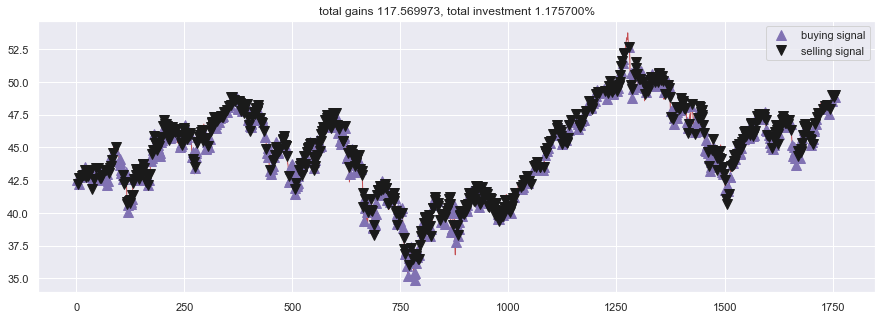

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()